In [1]:
# 201806
from __future__ import division
import numpy as np
import pandas as pd
import math
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('once', category=UserWarning)
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
m = [0, .25, 1, 2, 4]
x = [1.,5.,3., 3.,3.]
ns = len(x)-1
y = pd.DataFrame([m,x]).T
y.columns = ['m','x']
ns, x

(4, [1.0, 5.0, 3.0, 3.0, 3.0])

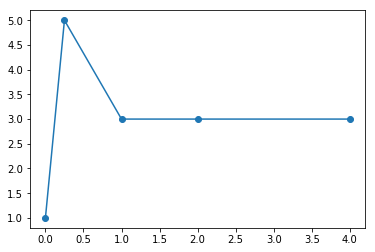

In [3]:
plt.plot(m,x,marker='o')
plt.show()

In [4]:
def cs(y, xtm=10, frq=12):
  # assume y=yield curve, 2 cols: mat & yld

  if type(y) != pd.core.frame.DataFrame:
    return('Error: need a data frame')

  if len(list(y.columns))!= 2:
    return('Error: need 2 column dataframe: maturity & yield')

  ns = len(y)-1  # ns is # of line segments (=#nodes-1)

  if ns < 2:
    return('Error: need bigger yield curve')

  y.columns = ['m','x']
  if y['m'].max() < xtm: xtm = y['m'].max()

  A = pd.DataFrame(np.zeros([4 * ns,4 * ns]))  # 4 coeff for cubic eqns

  for i in np.arange(ns):
    for j in np.arange(4):
      A.ix[i,4*i + j] = y.ix[i+1,'m']**j   # right-hand ends
      A.ix[ns+i,4*i + j] = y.ix[i,'m']**j  # left-hand ends

  for i in np.arange(ns-1):
    for j in np.arange(1,4):  # first derivatives
      A.ix[2*ns+i,4*i + j] = j*y.ix[i+1,'m']**(j-1)
      A.ix[2*ns+i,4*(i+1) + j] = -j*y.ix[i+1,'m']**(j-1)
    for k in np.arange(3,5):  # second derivatives
      A.ix[3*ns+i-1,4*i+k-1]=math.factorial(k-1)*y.ix[i+1,'m']**(k-3)
      A.ix[3*ns+i-1,4*(i+1)+k-1]=-math.factorial(k-1)*y.ix[i+1,'m']**(k-3)
    A.ix[4*ns-2,2] = 2.  # far left-hand end
    A.ix[4*ns-1, 4*ns-2] = 2.  # far right-hand end (with next row)
    A.ix[4*ns-1, 4*ns-1] = 6.*y.ix[ns,'m']

  B = pd.DataFrame(np.zeros(4*ns))

  for i in np.arange(ns):
    B.ix[i] = y.ix[i+1,'x']
    B.ix[ns+i] = y.ix[i,'x']

  z = np.linalg.solve(np.array(A),np.array(B))  # solve linear eqns
  zs=pd.DataFrame(pd.DataFrame(z).values.reshape([ns,4]))  # create coef matrix
  cn = list(zs.columns)
  zs['Strt'] = y['m']
  zs['End'] = y['m'].shift(-1)
  zs = zs[['Strt','End']+cn]

  sp = set(np.arange(0,float(xtm*frq+1))/float(frq))  # gather all maturities to output
  sp.update(y['m'])            # include any 'oddball' maturities from original yield curve
  sp = sorted(sp)
  sp = pd.DataFrame(sp)   # create output dataframe
  sp.columns = ['ms']     # column of maturities
  sp['xs'] = 0.0          # col of interpolated rates

  rw = 0
  for i in np.arange(len(sp)):  # calculate spline rates from coeffs
    while sp.ix[i]['ms'] > zs.ix[rw]['End']: rw = rw + 1
    sp.ix[i,'xs'] = zs.ix[rw,0] + zs.ix[rw,1]*sp.ix[i,'ms'] +\
                    zs.ix[rw,2]*sp.ix[i,'ms']**2 + zs.ix[rw,3]*sp.ix[i,'ms']**3

  return sp


sp2 = cs(y)
sp2.tail()

ms        xs
44  3.666667  3.342140
45  3.750000  3.259812
46  3.833333  3.174736
47  3.916667  3.087826
48  4.000000  3.000000

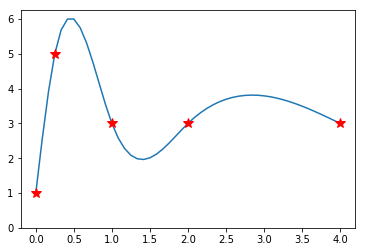

In [5]:
plt.plot(sp2['ms'],sp2['xs'])
plt.plot(y['m'],y['x'],'r ',marker='*',ms=10)
plt.ylim(ymin=min(0,sp2['xs'].min()))
plt.show()

In [6]:
#y = yc.copy()
#xtm = 30
#frq = 12

#if 1==1:
def ccs(y, xtm=10, frq=12):  # constrained cubic spline
  # assume y=yield curve, 2 cols: mat & yld

  if type(y) != pd.core.frame.DataFrame:
    return('Error: need a data frame')

  if len(list(y.columns))!= 2:
    return('Error: need 2 column dataframe: maturity & yield')

  ns = len(y)-1  # ns is # of line segments (=#nodes-1)

  if ns < 2:
    return('Error: need bigger yield curve')

  y.columns = ['m','x']
  if y['m'].max() < xtm: xtm = y['m'].max()


  C = pd.DataFrame(np.zeros([ns,7]))  # last 4 cols for cubic eqn coeffs (1st 3 for intermediate calcs)

  # internal node slopes:
  for i in np.arange(0,(ns-1)):
    if ((y.ix[i+2,'x']-y.ix[i+1,'x']==0)|(y.ix[i+1,'x']-y.ix[i,'x']==0)|\
       ((y.ix[i+2,'x']-y.ix[i+1,'x'])/(y.ix[i+1,'x']-y.ix[i,'x']+.000000001)<0)):
      C.ix[i,0] = 0.
    else:
      C.ix[i,0] = 2./((y.ix[i+2,'m']-y.ix[i+1,'m'])/(y.ix[i+2,'x']-y.ix[i+1,'x'])+\
                    (y.ix[i+1,'m']-y.ix[i,'m'])/(y.ix[i+1,'x']-y.ix[i,'x']))

  # left-end slope: (held by m0)
  if y.ix[0,'x']==y.ix[1,'x']:
    m0 = 0.
  else:
    m0 = (3.*(y.ix[1,'x']-y.ix[0,'x'])/2./(y.ix[1,'m']-y.ix[0,'m'])-C.ix[0,0]/2.)

  # right-end slopes:
  if y.ix[ns-1,'x']==y.ix[ns,'x']:
    C.ix[ns-1,0] = 0.
  else:
    C.ix[ns-1,0] = (3.*(y.ix[ns,'x']-y.ix[ns-1,'x'])/2./(y.ix[ns,'m']-y.ix[ns-1,'m'])-C.ix[ns-2,0]/2.)

  # left-end 2nd derivs:
  for i in np.arange(1,ns):
    C.ix[i,1] =-2.*(C.ix[i,0]+2.*C.ix[i-1,0])/(y.ix[i+1,'m']-y.ix[i,'m'])+6.*(y.ix[i+1,'x']-y.ix[i,'x'])/(y.ix[i+1,'m']-y.ix[i,'m'])**2

  # right-end 2nd derivs:
  i=0  ## special case for m0
  C.ix[i,2] = 2.*(2.*C.ix[i,0]+m0)/(y.ix[i+1,'m']-y.ix[i,'m'])-6.*(y.ix[i+1,'x']-y.ix[i,'x'])/(y.ix[i+1,'m']-y.ix[i,'m'])**2

  for i in np.arange(1,ns-1):
    C.ix[i,2] = 2.*(2.*C.ix[i,0]+C.ix[i-1,0])/(y.ix[i+1,'m']-y.ix[i,'m'])-6.*(y.ix[i+1,'x']-y.ix[i,'x'])/(y.ix[i+1,'m']-y.ix[i,'m'])**2

  # coefficients for solution:
  for i in np.arange(ns):
    C.ix[i,3] = (C.ix[i,2]-C.ix[i,1])/6/(y.ix[i+1,'m']-y.ix[i,'m'])  # D coeff
    C.ix[i,4] = (y.ix[i+1,'m']*C.ix[i,1]-y.ix[i,'m']*C.ix[i,2])/2/(y.ix[i+1,'m']-y.ix[i,'m'])  # C coeff
    C.ix[i,5] = ((y.ix[i+1,'x']-y.ix[i,'x'])-C.ix[i,4]*(y.ix[i+1,'m']**2-y.ix[i,'m']**2)-\
                 C.ix[i,3]*(y.ix[i+1,'m']**3-y.ix[i,'m']**3))/(y.ix[i+1,'m']-y.ix[i,'m'])  # B coeff
    C.ix[i,6] = y.ix[i,'x']-C.ix[i,5]*y.ix[i,'m']-C.ix[i,4]*y.ix[i,'m']**2-C.ix[i,3]*y.ix[i,'m']**3

  cC = list(C.columns)
  C['Strt'] = y['m']
  C['End'] = y['m'].shift(-1)
  C = C[['Strt','End']+cC]

  sp = set(np.arange(0,float(xtm*frq+1))/float(frq))  # gather all maturities to output
  sp.update(y['m'])            # include any 'oddball' maturities from original yield curve
  sp = sorted(sp)
  sp = pd.DataFrame(sp)   # create output dataframe
  sp.columns = ['ms']     # column of maturities
  sp['xs'] = 0.0          # col of interpolated rates

  rw = 0
  for i in np.arange(len(sp)):  # calculate spline rates from coeffs
    while sp.ix[i]['ms'] > C.ix[rw]['End']: rw = rw + 1
    sp.ix[i,'xs'] = C.ix[rw,6] + C.ix[rw,5]*sp.ix[i,'ms'] +\
                    C.ix[rw,4]*sp.ix[i,'ms']**2 + C.ix[rw,3]*sp.ix[i,'ms']**3

  return sp


In [7]:
spc = ccs(y)
spc.tail()

ms   xs
44  3.666667  3.0
45  3.750000  3.0
46  3.833333  3.0
47  3.916667  3.0
48  4.000000  3.0

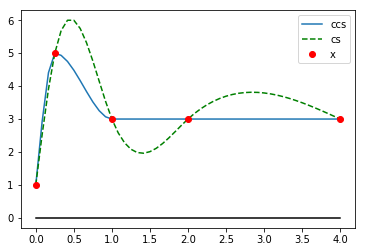

In [8]:
plt.plot(spc['ms'],spc['xs'],label='ccs')
plt.plot(sp2['ms'],sp2['xs'],'g--',label='cs')
plt.plot(y['m'],y['x'],'r ',marker='o')
plt.plot([0,4],[0,0],'k-')
plt.legend(loc=0)
plt.show()

In [9]:
def qs(y, xtm=10, frq=12):  ## quartic spline function
  # assume y=yield curve, 2 cols: mat & yld

  if type(y) != pd.core.frame.DataFrame:
    return('Error: need a data frame')

  if len(list(y.columns))!= 2:
    return('Error: need 2 column dataframe: maturity & yield')

  ns = len(y)-1  # ns is # of line segments (=#nodes-1)

  if ns < 2:
    return('Error: need bigger yield curve')

  y.columns = ['m','x']
  if y['m'].max() < xtm: xtm = y['m'].max()

  Q = pd.DataFrame(np.zeros([5 * ns,5 * ns]))  # 4 coeff for cubic eqns

  for i in np.arange(ns):
    for j in np.arange(5):
      Q.ix[i,5*i+j] = y.ix[i+1,'m']**j  # right-hand ends
      Q.ix[ns+i,5*i+j] = y.ix[i,'m']**j # left-hand ends

  for i in np.arange(ns-1):
    ## 1st derivatives:
    for j in np.arange(1,5):
      Q.ix[2*ns+i,5*i+j] = j*y.ix[i+1,'m']**(j-1)
      Q.ix[2*ns+i,5*(i+1)+j] = -j*y.ix[i+1,'m']**(j-1)
    ## 2nd derivatives:
    for k in np.arange(2,5):
      if k==4:
        kt=.5
      else:
        kt=1.
      Q.ix[3*ns+i-1,5*i+k] = math.factorial(k)*kt*y.ix[i+1,'m']**(k-2)
      Q.ix[3*ns+i-1,5*(i+1)+k] = -math.factorial(k)*kt*y.ix[i+1,'m']**(k-2)
    ## 3rd derivatives:
    for h in np.arange(3,5):
      Q.ix[4*ns+i-2,5*i+h] = math.factorial(h)*y.ix[i+1,'m']**(h-3)
      Q.ix[4*ns+i-2,5*(i+1)+h] = -math.factorial(h)*y.ix[i+1,'m']**(h-3)

    # far left-hand end (1 eqn)
    Q.ix[5*ns-3,2]  = 2.

    # far right-hand end (1 eqn) instantaneously straight (2nd deriv = 0)
    Q.ix[5*ns-2, 5*ns-3] = 2.
    Q.ix[5*ns-2, 5*ns-2] = 6.*y.ix[ns,'m']
    Q.ix[5*ns-2, 5*ns-1] = 12.*y.ix[ns,'m']**2

    # far right-hand end (3rd deriv = 0) NEW!!!! (instead of 1st deriv = 0)    
    Q.ix[5*ns-1, 5*ns-2] = 6.
    Q.ix[5*ns-1, 5*ns-1] = 24.*y.ix[ns,'m']

  R = np.zeros(5*ns)
  for i in np.arange(ns):
    R[i] = y.ix[i+1,'x']
    R[ns+i] = y.ix[i,'x']

  s = np.linalg.solve(np.array(Q),np.array(R))  # solve linear eqns
  ss=pd.DataFrame(pd.DataFrame(s).values.reshape([ns,5]))  # create coef matrix
  sscol = list(ss.columns)
  ss['Strt'] = y['m']
  ss['End'] = y['m'].shift(-1)
  ss = ss[['Strt','End']+sscol]

  sq = set(np.arange(0,float(xtm*frq+1))/float(frq))  # gather all maturities to output
  sq.update(y['m'])            # include any 'oddball' maturities from original yield curve
  sq = sorted(sq)
  sq = pd.DataFrame(sq)   # create output dataframe
  sq.columns = ['ms']     # column of maturities
  sq['xs'] = 0.0          # col of interpolated rates

  rw = 0
  for i in np.arange(len(sq)):  # calculate spline rates from coeffs
    while sq.ix[i]['ms'] > ss.ix[rw]['End']: rw = rw + 1
    sq.ix[i,'xs'] = ss.ix[rw,0] + ss.ix[rw,1]*sq.ix[i,'ms'] +\
                    ss.ix[rw,2]*sq.ix[i,'ms']**2 + ss.ix[rw,3]*sq.ix[i,'ms']**3 + ss.ix[rw,4]*sq.ix[i,'ms']**4

  return sq


In [10]:
sq2 = qs(y)

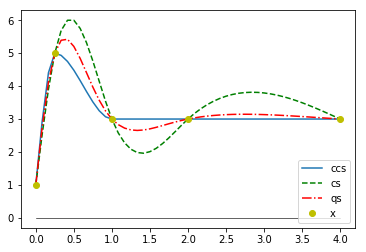

In [11]:
plt.plot(spc['ms'],spc['xs'],label='ccs')
plt.plot(sp2['ms'],sp2['xs'],'g--',label='cs')
plt.plot(sq2['ms'],sq2['xs'],'r-.',label='qs')
plt.plot(y['m'],y['x'],'y ',marker='o')
plt.plot([0,4],[0,0],'k-',lw=.6)
plt.legend(loc=4)
plt.show()

In [12]:
## test data for 2012-Jan (LibSwap):
rt=[0.08,0.282895238,0.5659,0.79697619,0.58,0.61,0.71,0.92,1.16,1.62,2.07]
mt=[0.,1.,3.,6.,12.,24.,36.,48.,60.,84.,120.]
mt = [x/12. for x in mt]

yc = pd.DataFrame([mt,rt]).T
yc.columns = ['m','x']

In [13]:
cb = cs(yc)
cc = ccs(yc)
qt = qs(yc)

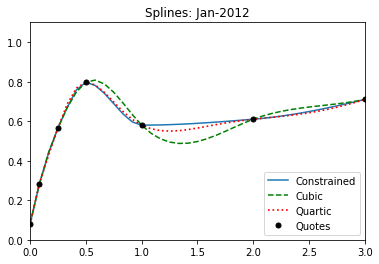

In [14]:
plt.plot(cc['ms'],cc['xs'],label='Constrained')
plt.plot(cb['ms'],cb['xs'],'g--',lw=1.5,label='Cubic')
plt.plot(qt['ms'],qt['xs'],'r:',lw=1.7,label='Quartic')
plt.plot(yc['m'],yc['x'],'k ',marker='o',ms=5,label='Quotes')
#plt.plot([0,4],[0,0],'k-',lw=.6)
plt.ylim([0,1.1])
plt.xlim([0,3])
plt.title('Splines: Jan-2012')
plt.legend(loc=4)
plt.show()

In [15]:
yc

m         x
0    0.000000  0.080000
1    0.083333  0.282895
2    0.250000  0.565900
3    0.500000  0.796976
4    1.000000  0.580000
5    2.000000  0.610000
6    3.000000  0.710000
7    4.000000  0.920000
8    5.000000  1.160000
9    7.000000  1.620000
10  10.000000  2.070000

In [16]:
## data for 2012-Jan (LibSwap):
#rt2=[0.08,0.282895238,0.5659,0.79697619,1.11454762,0.58,0.61,0.71,0.92,1.16,1.62,2.07]
#mt2=[0.,1.,3.,6.,11.,12.,24.,36.,48.,60.,84.,120.]
rt2=[0.08,0.282895238,0.5659,0.79697619,0.949480952,0.58,0.61,0.71,0.92,1.16,1.62,2.07]
mt2=[0.,1.,3.,6.,9.,12.,24.,36.,48.,60.,84.,120.]
mt2 = [x/12. for x in mt2]

yc2 = pd.DataFrame([mt2,rt2]).T
yc2.columns = ['m','x']

yc2

m         x
0    0.000000  0.080000
1    0.083333  0.282895
2    0.250000  0.565900
3    0.500000  0.796976
4    0.750000  0.949481
5    1.000000  0.580000
6    2.000000  0.610000
7    3.000000  0.710000
8    4.000000  0.920000
9    5.000000  1.160000
10   7.000000  1.620000
11  10.000000  2.070000

In [17]:
## repeat splines including L12m:
cb2 = cs(yc2)
cc2 = ccs(yc2)
qt2 = qs(yc2)

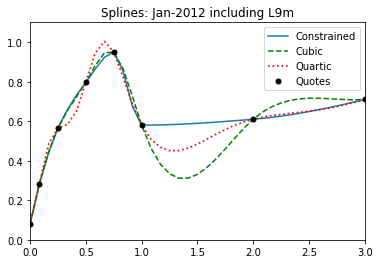

In [18]:
plt.plot(cc2['ms'],cc2['xs'],label='Constrained')
plt.plot(cb2['ms'],cb2['xs'],'g--',lw=1.5,label='Cubic')
plt.plot(qt2['ms'],qt2['xs'],'r:',lw=1.7,label='Quartic')
plt.plot(yc2['m'],yc2['x'],'k ',marker='o',ms=5,label='Quotes')
#plt.plot([0,4],[0,0],'k-',lw=.6)
plt.ylim([0,1.1])
plt.xlim([0,3])
plt.title('Splines: Jan-2012 including L9m')
plt.legend(loc=0)
plt.show()

In [19]:
ls = pd.read_csv('LibSwap_LongHist_30y_201806.csv',index_col=0)
ls.index = pd.to_datetime(ls.index)
ls.dropna(axis=0,how='all',inplace=True)
lscol= list(ls.columns)
ls.tail(5)

F1d       L1m       L3m       L6m      L12m       S1y       S2y  \
Date                                                                           
2018-03-01  1.51  1.799131  2.173358  2.345182  2.596476  2.371238  2.571714   
2018-04-01  1.69  1.896724  2.349426  2.493658  2.735546  2.496659  2.674476   
2018-05-01  1.70  1.946290  2.335609  2.499740  2.754757  2.547499  2.755000   
2018-06-01  1.82  2.068429  2.330264  2.495895  2.759644  2.593907  2.792762   
2018-07-01  1.91  2.078999  2.339118  2.519525  2.794493  2.642810  2.833048   

                 S3y       S4y       S5y       S7y      S10y      S30y  Prime  \
Date                                                                            
2018-03-01  2.675810  2.730952  2.764476  2.812857  2.872810  2.935810   4.58   
2018-04-01  2.761238  2.803143  2.826143  2.856381  2.898095  2.934810   4.75   
2018-05-01  2.852137  2.900386  2.927636  2.966045  3.014409  3.040500   4.75   
2018-06-01  2.868619  2.899474  2.914524  2.936429  2.974381  2.983524   4.89   
2018-07-01  2.892429  2.911238  2.916905  2.927143  2.955190  2.956095   5.00   

            L9m  
Date             
2018-03-01  NaN  
2018-04-01  NaN  
2018-05-01  NaN  
2018-06-01  NaN  
2018-07-01  NaN

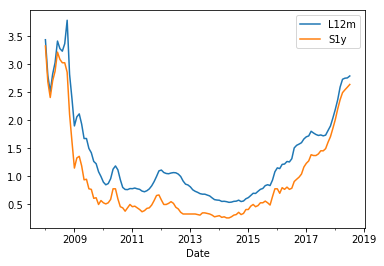

In [20]:
ls.ix['2008':][['L12m','S1y']].plot()

In [21]:
lscolx = lscol[0:-2]
lscolx

['F1d',
 'L1m',
 'L3m',
 'L6m',
 'L12m',
 'S1y',
 'S2y',
 'S3y',
 'S4y',
 'S5y',
 'S7y',
 'S10y',
 'S30y']

In [22]:
## isolate one yield curve (3/1/2009:  big L12m distortion)
yb = pd.DataFrame(ls.ix['2009-03-01'][lscolx])
yb.columns = ['x']
yb.drop(['L12m'],inplace=True)
mlst=[0,1,3,6,12,24,36,48,60,84,120,360]
yb['m'] = [x/12. for x in mlst]
mlst2=[0,1,3,6,12,24,36,48,60,84,120,360]
yb=yb[['m','x']]
ybm = yb.set_index('m',drop=True)
yb

m        x
F1d    0.000000  0.18000
L1m    0.083333  0.53249
L3m    0.250000  1.26674
L6m    0.500000  1.82727
S1y    1.000000  1.36000
S2y    2.000000  1.60000
S3y    3.000000  1.93000
S4y    4.000000  2.23000
S5y    5.000000  2.46000
S7y    7.000000  2.80000
S10y  10.000000  3.07000
S30y  30.000000  3.34000

In [23]:
yb2 = pd.DataFrame(ls.ix['2009-03-01'][lscolx])
yb2.columns = ['x']
mlst2=[0,1,3,6,12,12,24,36,48,60,84,120,360]
yb2['m'] = [x/12. for x in mlst2]
yb2.reset_index(drop=True, inplace=True)
yb2 = yb2[['m','x']]
yb2m=yb2.set_index('m',drop=True)
yb2

m        x
0    0.000000  0.18000
1    0.083333  0.53249
2    0.250000  1.26674
3    0.500000  1.82727
4    1.000000  2.11725
5    1.000000  1.36000
6    2.000000  1.60000
7    3.000000  1.93000
8    4.000000  2.23000
9    5.000000  2.46000
10   7.000000  2.80000
11  10.000000  3.07000
12  30.000000  3.34000

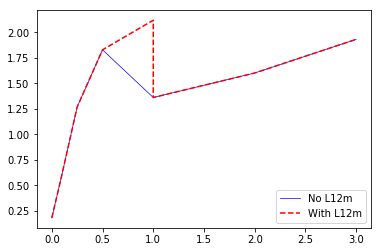

In [24]:
x = 7
plt.plot(yb.ix[0:x]['m'],yb.ix[0:x]['x'],'b',lw=.7,label='No L12m')
plt.plot(yb2.ix[0:x]['m'],yb2.ix[0:x]['x'],'r--',lw=1.5,label='With L12m')
plt.legend(loc=4)
plt.show()

In [25]:
### set-up for dfspot function:
xtm = 30  # max term
frq = 12  # freq of cash flows
zeroto = 1
ls.columns[-1]

'L9m'

In [26]:
## remove L12m columns from ls table:
lt=ls[lscolx].drop('L12m',axis=1).copy()
lt['2012']

F1d      L1m      L3m      L6m   S1y   S2y   S3y   S4y   S5y  \
Date                                                                        
2012-01-01  0.08  0.28290  0.56590  0.79698  0.58  0.61  0.71  0.92  1.16   
2012-02-01  0.10  0.25002  0.50324  0.75729  0.50  0.56  0.67  0.87  1.10   
2012-03-01  0.13  0.24185  0.47329  0.74128  0.50  0.59  0.75  0.99  1.25   
2012-04-01  0.14  0.23983  0.46681  0.73140  0.52  0.58  0.71  0.93  1.17   
2012-05-01  0.16  0.23893  0.46653  0.73299  0.55  0.61  0.71  0.88  1.09   
2012-06-01  0.16  0.24320  0.46559  0.73640  0.52  0.57  0.65  0.80  0.99   
2012-07-01  0.16  0.24646  0.45355  0.73022  0.45  0.48  0.54  0.67  0.85   
2012-08-01  0.13  0.23784  0.43260  0.71778  0.42  0.46  0.55  0.70  0.90   
2012-09-01  0.14  0.22134  0.38563  0.67168  0.36  0.39  0.47  0.61  0.81   
2012-10-01  0.16  0.21347  0.33049  0.58230  0.33  0.39  0.48  0.63  0.83   
2012-11-01  0.16  0.20889  0.31102  0.52835  0.33  0.38  0.46  0.60  0.78   
2012-12-01  0.16  0.21093  0.30947  0.51457  0.33  0.38  0.47  0.61  0.81   

             S7y  S10y  S30y  
Date                          
2012-01-01  1.62  2.07  2.73  
2012-02-01  1.57  2.05  2.80  
2012-03-01  1.74  2.23  2.96  
2012-04-01  1.64  2.13  2.89  
2012-05-01  1.50  1.94  2.65  
2012-06-01  1.36  1.77  2.44  
2012-07-01  1.21  1.63  2.35  
2012-08-01  1.32  1.78  2.55  
2012-09-01  1.25  1.77  2.64  
2012-10-01  1.26  1.77  2.67  
2012-11-01  1.19  1.68  2.55  
2012-12-01  1.23  1.75  2.67

In [27]:
## change col names to number of months
mlst = [0,1,3,6,12,24,36,48,60,84,120,360]
lt.columns = [x for x in mlst]
lt.tail(2)

0         1         3         6         12        24        36   \
Date                                                                           
2018-06-01  1.82  2.068429  2.330264  2.495895  2.593907  2.792762  2.868619   
2018-07-01  1.91  2.078999  2.339118  2.519525  2.642810  2.833048  2.892429   

                 48        60        84        120       360  
Date                                                          
2018-06-01  2.899474  2.914524  2.936429  2.974381  2.983524  
2018-07-01  2.911238  2.916905  2.927143  2.955190  2.956095

In [28]:
dt = pd.to_datetime('2012-01-01')
yc=lt.ix[dt]
yc

0      0.08000
1      0.28290
3      0.56590
6      0.79698
12     0.58000
24     0.61000
36     0.71000
48     0.92000
60     1.16000
84     1.62000
120    2.07000
360    2.73000
Name: 2012-01-01 00:00:00, dtype: float64

In [29]:
dt.strftime('%Y-%m-%d')

'2012-01-01'

In [30]:
lti=lt.ix[dt]
lti

0      0.08000
1      0.28290
3      0.56590
6      0.79698
12     0.58000
24     0.61000
36     0.71000
48     0.92000
60     1.16000
84     1.62000
120    2.07000
360    2.73000
Name: 2012-01-01 00:00:00, dtype: float64

In [31]:
###################################################
## fix accrual daycounts!!!!!!!!!!
###################################################
ltx = lti.copy()
for i in list(ltx.index):
  if i < zeroto * 12:
    ltx[i] = ltx[i] * 365./360.
    
ltx

0      0.081111
1      0.286829
3      0.573760
6      0.808049
12     0.580000
24     0.610000
36     0.710000
48     0.920000
60     1.160000
84     1.620000
120    2.070000
360    2.730000
Name: 2012-01-01 00:00:00, dtype: float64

In [32]:
ltx/lti

0      1.013889
1      1.013889
3      1.013889
6      1.013889
12     1.000000
24     1.000000
36     1.000000
48     1.000000
60     1.000000
84     1.000000
120    1.000000
360    1.000000
Name: 2012-01-01 00:00:00, dtype: float64

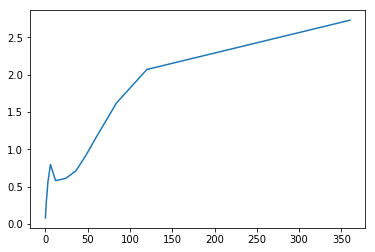

In [33]:
lti.plot()

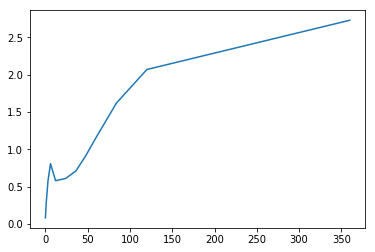

In [34]:
ltx.plot()

In [35]:
## build dataframe to conform to ccs function:
yc = pd.DataFrame(ltx)
yc.columns = ['x']
yc['m'] = yc.index / 12.
yc.reset_index(drop=True,inplace=True)
yc = yc[['m','x']]
yc

m         x
0    0.000000  0.081111
1    0.083333  0.286829
2    0.250000  0.573760
3    0.500000  0.808049
4    1.000000  0.580000
5    2.000000  0.610000
6    3.000000  0.710000
7    4.000000  0.920000
8    5.000000  1.160000
9    7.000000  1.620000
10  10.000000  2.070000
11  30.000000  2.730000

In [36]:
def fyc(yc):
  y2 = pd.DataFrame(yc)
  y2.columns = ['x']
  y2['m'] = y2.index / 12.
  y2.reset_index(drop=True,inplace=True)
  y2 = y2[['m','x']]
  return y2

In [37]:
yc2=fyc(lt.ix['2012-01-01'])
yc2

m        x
0    0.000000  0.08000
1    0.083333  0.28290
2    0.250000  0.56590
3    0.500000  0.79698
4    1.000000  0.58000
5    2.000000  0.61000
6    3.000000  0.71000
7    4.000000  0.92000
8    5.000000  1.16000
9    7.000000  1.62000
10  10.000000  2.07000
11  30.000000  2.73000

In [38]:
## ccs spline 30y monthly:
c30 = ccs(yc,xtm=30,frq=12)
len(c30)

361

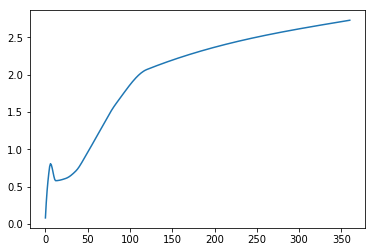

In [39]:
c30['xs'].plot()

In [40]:
c30.tail()

ms        xs
356  29.666667  2.722515
357  29.750000  2.724387
358  29.833333  2.726258
359  29.916667  2.728129
360  30.000000  2.730000

In [41]:
n = len(c30)
df = pd.Series(np.zeros(n))
spt = pd.Series(np.zeros(n))
n

361

In [42]:
sdf = 0
ii = 0

In [43]:
iy=c30.copy()

In [44]:
df[0]= 1
spt[0] = iy.ix[0,'xs']
ii = 1
df[0], spt[0]

(1.0, 0.0811111111111111)

In [45]:
## process zero coupon rates:
for i in np.arange(ii,frq):
  df[i] = 1./(1+iy.ix[i,'xs']*iy.ix[i,'ms']/100.) 
  #df[i]=1/(1+iy[i,2]*im[i]/(per * 100))
  #spot[i]=(-100*log(df[i])/iy[i,1])
  spt[i]= (-100.*np.log(df[i])/iy.ix[i,'ms'])

In [46]:
iy[0:6]

ms        xs
0  0.000000  0.081111
1  0.083333  0.286829
2  0.166667  0.447271
3  0.250000  0.573760
4  0.333333  0.679452
5  0.416667  0.769783

In [47]:
## process coupon periods:
for i in np.arange(frq,len(iy)):
  fr= (6.-iy.index[i]%6) / 6.
  sdf = df[0:i][df[0:i].index.to_series()%6==iy.index[i]%6].sum()
  if (iy.index[i]%6 == 0):
    fr=0.
    sdf = sdf - 1 # need to remove 0 maturity df
  df[i] = (1. + (fr - sdf) * iy.ix[i, 'xs'] / 2. / 100.) / ( 1. + iy.ix[i,'xs']/2./100.)
  spt[i]=(-100.*np.log(df[i])/iy.ix[i,'ms'])


In [48]:
df[10:16]

10    0.994702
11    0.994558
12    0.994228
13    0.993746
14    0.993256
15    0.992759
dtype: float64

In [49]:
spt[10:16]

10    0.637428
11    0.595266
12    0.578831
13    0.579140
14    0.580009
15    0.581404
dtype: float64

In [50]:
df[-5:]

356    0.426082
357    0.424732
358    0.423382
359    0.422035
360    0.420689
dtype: float64

In [51]:
iy['df'] = df

In [52]:
spt.tail()

356    2.875694
357    2.878312
358    2.880937
359    2.883567
360    2.886208
dtype: float64

In [53]:
iy['spt'] = spt
iy.tail()

ms        xs        df       spt
356  29.666667  2.722515  0.426082  2.875694
357  29.750000  2.724387  0.424732  2.878312
358  29.833333  2.726258  0.423382  2.880937
359  29.916667  2.728129  0.422035  2.883567
360  30.000000  2.730000  0.420689  2.886208

In [54]:
iy.to_csv("iy_"+dt.strftime('%Y-%m-%d')+".csv") # parspotdf table

In [55]:
"iy_"+dt.strftime('%Y-%m-%d')+".csv"

'iy_2012-01-01.csv'

In [56]:
iy.head()

ms        xs        df       spt
0  0.000000  0.081111  1.000000  0.081111
1  0.083333  0.286829  0.999761  0.286795
2  0.166667  0.447271  0.999255  0.447104
3  0.250000  0.573760  0.998568  0.573349
4  0.333333  0.679452  0.997740  0.678683

In [57]:
# build dfs function (df,spot,par365). input is yc table only.
#zeroto = 1
#yc = fyc(lt.ix['2008-03-01'])

#if 1==1:
def dfs(yc, zeroto=1):
  xtm = yc['m'].max()
  yx = yc.copy()

  # adjust ff, libor to 365 accruals:
  i = 0
  while (yx.ix[i]['m'] < zeroto) & (i < len(yx)):
    yx.ix[i]['x'] = yx.ix[i]['x'] * 365/360
    i += 1

  sp = ccs(yx,xtm=xtm)
  n = len(sp)
  df = pd.Series(np.zeros(n)) # holds df
  spt = pd.Series(np.zeros(n)) # holds spot

  # initialize sdf (sum of dfs), set first row to df=1, spt=ff rate
  sdf = 0
  df[0]= 1
  spt[0] = sp.ix[0,'xs']

  # process spot rates:
  for i in np.arange(1,12):  # 1 to 11 month libor rates
    df[i] = 1./(1.+sp.ix[i,'xs']*sp.ix[i,'ms']/100.) 
    spt[i]= (-100.*np.log(df[i])/sp.ix[i,'ms'])

  ## process coupon periods:
  for i in np.arange(12,n):
    fr=(6.-sp.index[i]%6) / 6.
    sdf = df[0:i][df[0:i].index.to_series()%6==sp.index[i]%6].sum()
    if (sp.index[i]%6 == 0):
      fr=0.
      sdf = sdf - 1 # need to remove 0 maturity df
    df[i] = (1. + (fr - sdf) * sp.ix[i, 'xs'] / 2. / 100.) / ( 1. + sp.ix[i,'xs']/2./100.)
    spt[i]=(-100.*np.log(df[i])/sp.ix[i,'ms'])

  sp['df'] = df
  sp['spt'] = spt

  return sp

In [58]:
sp = dfs(yc)
sp[-4:]

ms        xs        df       spt
357  29.750000  2.724387  0.424732  2.878309
358  29.833333  2.726258  0.423383  2.880934
359  29.916667  2.728129  0.422035  2.883564
360  30.000000  2.730000  0.420689  2.886205

In [59]:
iy[-4:]

ms        xs        df       spt
357  29.750000  2.724387  0.424732  2.878312
358  29.833333  2.726258  0.423382  2.880937
359  29.916667  2.728129  0.422035  2.883567
360  30.000000  2.730000  0.420689  2.886208

In [60]:
lt.tail()

0         1         3         6         12        24        36   \
Date                                                                           
2018-03-01  1.51  1.799131  2.173358  2.345182  2.371238  2.571714  2.675810   
2018-04-01  1.69  1.896724  2.349426  2.493658  2.496659  2.674476  2.761238   
2018-05-01  1.70  1.946290  2.335609  2.499740  2.547499  2.755000  2.852137   
2018-06-01  1.82  2.068429  2.330264  2.495895  2.593907  2.792762  2.868619   
2018-07-01  1.91  2.078999  2.339118  2.519525  2.642810  2.833048  2.892429   

                 48        60        84        120       360  
Date                                                          
2018-03-01  2.730952  2.764476  2.812857  2.872810  2.935810  
2018-04-01  2.803143  2.826143  2.856381  2.898095  2.934810  
2018-05-01  2.900386  2.927636  2.966045  3.014409  3.040500  
2018-06-01  2.899474  2.914524  2.936429  2.974381  2.983524  
2018-07-01  2.911238  2.916905  2.927143  2.955190  2.956095

In [61]:
## function to process libswap curve table using ccs
## assume that col names are month maturities, xtm = col.max()/12
#yt = lt['2012'].copy()  ## use this table for testing yt = yield table
ytc = lt.copy()
len(ytc) # 643

643

In [62]:
## steps:  1. 360 to 365 rates (zeros) 2. ccs 3. df/spot calcs 4. output table (yo)
## input yldcurve table: yt (dates are row indices, #months are col headers)
def ccsx(y, zeroto=.99999):  # creates ccs splines for table of libor-swap monthly rates
##
#zeroto = .9999
#yt = ytc.copy()
#if 1==1:
##
  yt = y.copy()
  spt = []  # holds output table
  ms = [x/12. for x in list(yt.columns)]  # mat list in years
  mn = [x for x in list(yt.columns)]  # mat list in months
  alst = [x for x in list(yt.columns) if x < zeroto * 12]  # adjustment list for accrual 360 to 365
  xtm = yt.columns.max()/12.  # max term of yield curve
  ns=len(ms)-1  # number of spline segments (#modes - 1)

  yt[alst] = yt[alst] * 365./360.  # adjust 360d to 365d accrual for FF, libor
    

  C = pd.DataFrame(np.zeros([ns,7]))  # holds slopes and coefficients of line segements
  cC = list(C.columns)
  C['Strt'] = pd.DataFrame(ms)
  C['End'] = pd.DataFrame(ms).shift(-1)
  C = C[['Strt','End']+cC]

  for k in np.arange(len(yt)):
    xs = yt.ix[k]
    # internal node slopes:
    for i in np.arange(0,(ns-1)):
      if ((xs[mn[i+2]]-xs[mn[i+1]]==0)|(xs[mn[i+1]]-xs[mn[i]]==0)|\
         ((xs[mn[i+2]]-xs[mn[i+1]])/(xs[mn[i+1]]-xs[mn[i]]+.000000001)<0)):
        C.ix[i,0] = 0.
      else:
        C.ix[i,0] = 2./((ms[i+2]-ms[i+1])/(xs[mn[i+2]]-xs[mn[i+1]])+\
                      (ms[i+1]-ms[i])/(xs[mn[i+1]]-xs[mn[i]]))

    # left-end slope: (held by m0)
    if xs[mn[0]]==xs[mn[1]]:
      m0 = 0.
    else:
      m0 = (3.*(xs[mn[1]]-xs[mn[0]])/2./(ms[1]-ms[0])-C.ix[0,0]/2.)

    # right-end slope:
    if xs[mn[ns-1]]==xs[mn[ns]]:
      C.ix[ns-1,0] = 0.
    else:
      C.ix[ns-1,0] = (3.*(xs[mn[ns]]-xs[mn[ns-1]])/2./(ms[ns]-ms[ns-1])-C.ix[ns-2,0]/2.)

    # left-end 2nd derivs:
    for i in np.arange(1,ns):
      C.ix[i,1] =-2.*(C.ix[i,0]+2.*C.ix[i-1,0])/(ms[i+1]-ms[i])+6.*(xs[mn[i+1]]-xs[mn[i]])/(ms[i+1]-ms[i])**2

    # right-end 2nd derivs:
    i=0  ## special case for m0
    C.ix[i,2] = 2.*(2.*C.ix[i,0]+m0)/(ms[i+1]-ms[i])-6.*(xs[mn[i+1]]-xs[mn[i]])/(ms[i+1]-ms[i])**2
    for i in np.arange(1,ns-1):
      C.ix[i,2] = 2.*(2.*C.ix[i,0]+C.ix[i-1,0])/(ms[i+1]-ms[i])-6.*(xs[mn[i+1]]-xs[mn[i]])/(ms[i+1]-ms[i])**2

    # coefficients for solution:
    for i in np.arange(ns):
      C.ix[i,3] = (C.ix[i,2]-C.ix[i,1])/6./(ms[i+1]-ms[i])  # D coeff
      C.ix[i,4] = (ms[i+1]*C.ix[i,1]-ms[i]*C.ix[i,2])/2./(ms[i+1]-ms[i])  # C coeff
      C.ix[i,5] = ((xs[mn[i+1]]-xs[mn[i]])-C.ix[i,4]*(ms[i+1]**2-ms[i]**2)-\
                   C.ix[i,3]*(ms[i+1]**3-ms[i]**3))/float(ms[i+1]-ms[i])  # B coeff
      C.ix[i,6] = xs[mn[i]]-C.ix[i,5]*ms[i]-C.ix[i,4]*ms[i]**2-C.ix[i,3]*ms[i]**3

    sp = pd.DataFrame(np.zeros(int(xtm*frq+1)),columns=['xs'])          # col of interpolated rates

    rw = 0
    for j in np.arange(len(sp)):  # calculate spline rates from coeffs
      while (j/12.) > C.ix[rw]['End']: rw = rw + 1
      sp.ix[j,'xs'] = C.ix[rw,6] + C.ix[rw,5]*(j/12.) +\
                      C.ix[rw,4]*(j/12.)**2 + C.ix[rw,3]*(j/12.)**3

    if len(spt)==0:
      spt = sp.T.copy()
    else:
      spt = pd.concat([spt,sp.T.copy()],axis=0)

  spt['Date'] = list(yt.index)  # add dates as another column
  spt.set_index('Date', drop=True, inplace=True)  # move date to row index position
  return spt

In [63]:
import time

In [64]:
warnings.simplefilter('once', category=UserWarning)
%time sp2 = ccsx(ytc)  # longhist takes 1min 47sec

Wall time: 1min 47s


In [65]:
if len(sp2) > 500: spbig = sp2.copy()  ## sp636 is longhist ccs 360mnth splines (par365 rates)
len(sp2) # 643

643

In [66]:
sp2.head(2)

0         1         2         3         4         5    \
Date                                                                     
1965-01-01  3.954167  4.295444  4.504441  4.636722  4.706450  4.758330   
1965-02-01  4.035278  4.396833  4.626110  4.758389  4.800324  4.828924   

                 6         7         8         9      ...          351  \
Date                                                  ...                
1965-01-01  4.778666  4.773817  4.761695  4.745936    ...     4.929627   
1965-02-01  4.839500  4.838293  4.835275  4.831352    ...     4.949451   

                 352       353       354       355       356       357  \
Date                                                                     
1965-01-01  4.929383  4.929138  4.928894  4.928650  4.928406  4.928161   
1965-02-01  4.949205  4.948960  4.948714  4.948469  4.948223  4.947978   

                 358       359       360  
Date                                      
1965-01-01  4.927917  4.927672  4.927428  
1965-02-01  4.947732  4.947487  4.947241  

[2 rows x 361 columns]

In [67]:
sp2[[0,3,6,12,24,60,120,360]].tail()

0         3         6         12        24        60   \
Date                                                                     
2018-03-01  1.530972  2.203543  2.377754  2.371238  2.571714  2.764476   
2018-04-01  1.713472  2.382057  2.528292  2.496659  2.674476  2.826143   
2018-05-01  1.723611  2.368048  2.534459  2.547499  2.755000  2.927636   
2018-06-01  1.845278  2.362629  2.530560  2.593907  2.792762  2.914524   
2018-07-01  1.936528  2.371606  2.554519  2.642810  2.833048  2.916905   

                 120       360  
Date                            
2018-03-01  2.872810  2.935810  
2018-04-01  2.898095  2.934810  
2018-05-01  3.014409  3.040500  
2018-06-01  2.974381  2.983524  
2018-07-01  2.955190  2.956095

In [68]:
if len(sp2) > 50: sp2.to_csv('ccs_all365_longhist_30yr_201806.csv')  # par rates are all 365-day (FF, libor)

In [69]:
.12*365/360

0.12166666666666666

In [70]:
len(list(sp2.columns))

361

In [71]:
#yiz = sp636.copy()
def df_spt(yiz):  ## function to process multidate table of lib-swap curves:  generates dfs, spots, par365s
#if 1==1:
  yi = yiz.copy()
  n = len(list(yi.columns))
  fm = 3 ## forward maturity (=3month)
  spts = pd.DataFrame(index=np.arange(len(yi)),columns=np.arange(361))
  dfs = pd.DataFrame(index=np.arange(len(yi)),columns=np.arange(361))
  fwds= pd.DataFrame(index=np.arange(len(yi)),columns=np.arange(361-fm))
  df = pd.Series(np.zeros(n)) # holds df
  spt = pd.Series(np.zeros(n)) # holds spot
  fwd = pd.Series(np.zeros(n-fm)) # holds fwd
  for k in np.arange(len(yi)):  # len(y)
    z = yi.ix[k] # process kth row of table
    # initialize sdf (sum of dfs), set first row to df=1, spt=ff rate
    sdf = 0.
    df[0]= 1.
    spt[0] = z[0]
    # process spot rates:
    for i in np.arange(1,12):  # 1 to 11 month libor rates
      df[i] = 1./(1.+z[i]*i/1200.) 
      spt[i]= (-1200.*np.log(df[i])/i)
    ## process coupon periods:
    for i in np.arange(12,n):  # (12,n)
      fr=(6. - i%6) / 6.
      sdf = df[0:i][df[0:i].index.to_series()%6==i%6].sum()
      if (i%6 == 0):
        fr=0.
        sdf = sdf - 1 # need to remove 0 maturity df
      df[i] = (1. + (fr - sdf) * z[i] / 2. / 100.) / ( 1. + z[i]/2./100.)
      spt[i]=(-1200.*np.log(df[i])/i)
    ## process 3m forward rates:
    for i in np.arange(0,(n-fm)):
      fwd[i] = -100.*np.log(df[i+fm]/df[i])/(fm/12.)
    
    spts.iloc[k] = list(spt)    
    dfs.iloc[k] = list(df)    
    fwds.iloc[k] = list(fwd) 

  spts['Date'] = list(yi.index)  # add dates as another column
  spts.set_index('Date', drop=True, inplace=True)  # move date to row index position
  dfs['Date'] = list(yi.index)  # add dates as another column
  dfs.set_index('Date', drop=True, inplace=True)  # move date to row index position
  fwds['Date'] = list(yi.index)  # add dates as another column
  fwds.set_index('Date', drop=True, inplace=True)  # move date to row index position

  spts['Desc']= 'spot'
  spts.reset_index(drop=False,inplace=True)
  spts.set_index(['Desc','Date'],drop=True,inplace=True)
  dfs['Desc']= 'df'
  dfs.reset_index(drop=False,inplace=True)
  dfs.set_index(['Desc','Date'],drop=True,inplace=True)

  fwds['Desc']= 'fwd'+str(fm)
  fwds.reset_index(drop=False,inplace=True)
  fwds.set_index(['Desc','Date'],drop=True,inplace=True)

  xds = pd.concat([dfs,spts,fwds],axis=0)
  return xds


In [72]:
#%time df_sp = df_spt(sp2)  # 12 rows
%time df_sp = df_spt(spbig) # 3min 47sec

Wall time: 3min 44s


In [73]:
if len(df_sp)>500: df_sp.to_csv("df_spot_fwd3_longhist_30y_201806.csv")
len(df_sp) # 1929

1929

In [74]:
df_sp.tail(3)

0        1        2        3        4        5    \
Desc Date                                                               
fwd3 2018-05-01  2.36107  2.59451  2.69272    2.676  2.62637  2.55674   
     2018-06-01  2.35568  2.53805  2.63992  2.67369  2.66003  2.62176   
     2018-07-01   2.3646  2.55248  2.66872  2.71208   2.7101  2.68217   

                     6        7        8        9   ...       351      352  \
Desc Date                                           ...                      
fwd3 2018-05-01  2.51485   2.5085  2.50624  2.57405 ...   3.05945    3.057   
     2018-06-01  2.59515  2.59247  2.59832  2.68602 ...      2.98  2.97622   
     2018-07-01  2.66295  2.66463  2.67304  2.76467 ...   2.94272  2.93888   

                     353      354      355      356      357  358  359  360  
Desc Date                                                                    
fwd3 2018-05-01  3.05203  3.04577  3.04861  3.05398  3.06066  NaN  NaN  NaN  
     2018-06-01  2.97099  2.96554  2.96944   2.9748  2.98038  NaN  NaN  NaN  
     2018-07-01  2.93372   2.9283  2.93215  2.93733  2.94275  NaN  NaN  NaN  

[3 rows x 361 columns]

In [75]:
len(spbig) # 643

643

In [76]:
df_sp.loc['fwd3'].head()

0        1        2        3        4        5        6    \
Date                                                                        
1965-01-01  4.61005  4.79729  4.86121  4.83489  4.76008  4.64752  4.54533   
1965-02-01  4.73031  4.88683  4.89606  4.83344  4.78321   4.7223  4.67389   
1965-03-01  4.73031  4.86999  4.87411  4.81364  4.75688  4.67032  4.57766   
1965-04-01  4.73031  4.85486  4.85329  4.79384  4.74396  4.67192  4.59726   
1965-05-01  4.69023  4.80647  4.80806  4.75471  4.70377  4.62719  4.54533   

                7        8        9   ...       351      352      353  \
Date                                  ...                               
1965-01-01   4.4778  4.43541  4.64082 ...   4.70939  4.69264  4.67226   
1965-02-01  4.64322  4.61892  4.82546 ...   4.72894  4.71159  4.68973   
1965-03-01  4.50167  4.45492  4.66526 ...   4.67387  4.65507  4.63271   
1965-04-01  4.53662  4.49752  4.70546 ...   4.72061  4.70189  4.67975   
1965-05-01   4.4778  4.43541  4.64082 ...   4.72936  4.71066  4.68869   

                354      355      356      357  358  359  360  
Date                                                           
1965-01-01  4.65447  4.66872  4.68661   4.7019  NaN  NaN  NaN  
1965-02-01  4.67075  4.68558  4.70492  4.72139  NaN  NaN  NaN  
1965-03-01  4.61405  4.62973  4.64896   4.6645  NaN  NaN  NaN  
1965-04-01  4.66137  4.67758  4.69721  4.71309  NaN  NaN  NaN  
1965-05-01  4.67034  4.68653  4.70597   4.7218  NaN  NaN  NaN  

[5 rows x 361 columns]

In [77]:
df_sp.loc['spot'].head()

0        1        2        3        4        5        6    \
Date                                                                        
1965-01-01  3.95417  4.28777  4.48762  4.61005  4.66991  4.71177  4.72247   
1965-02-01  4.03528   4.3888  4.60837  4.73031  4.76232  4.78099  4.78188   
1965-03-01  4.09611   4.4191  4.61983  4.73031  4.75727  4.77239  4.77198   
1965-04-01  4.14681  4.44436   4.6296  4.73031  4.75224  4.76381  4.76208   
1965-05-01  4.15694   4.4292  4.59783  4.69023  4.71215  4.72397  4.72247   

                7        8        9     ...         351      352      353  \
Date                                    ...                                 
1965-01-01  4.70856  4.68768  4.66342   ...     4.85525  4.85479  4.85439   
1965-02-01  4.77127  4.75898  4.74588   ...     4.87304  4.87259  4.87219   
1965-03-01   4.7571  4.73412   4.7072   ...     4.85763  4.85707  4.85657   
1965-04-01  4.74869  4.72935  4.70714   ...     4.86276  4.86232  4.86193   
1965-05-01  4.70856  4.68768  4.66342   ...     4.87297  4.87252  4.87213   

                354      355      356      357      358      359      360  
Date                                                                       
1965-01-01  4.85401  4.85342  4.85285  4.85233  4.85187  4.85146  4.85108  
1965-02-01  4.87182  4.87123  4.87066  4.87013  4.86967  4.86927  4.86889  
1965-03-01  4.85608  4.85536  4.85468  4.85404  4.85347  4.85296  4.85246  
1965-04-01  4.86156  4.86096  4.86039  4.85988  4.85942  4.85903  4.85865  
1965-05-01  4.87175  4.87115  4.87058  4.87006   4.8696   4.8692  4.86882  

[5 rows x 361 columns]

In [78]:
#### STOP HERE (2017) #############################
## following sections are for special exhibits only

In [79]:
## MV and duration calc:

In [80]:
np.dot([1,2],[3,4])

11

In [81]:
## par MV of new bond:
c=spbig.ix['2015-10-01',60]
c

1.4

In [82]:
d=df_sp.ix['df','2015-10-01'][[x*6 for x in np.arange(1,11)]]
d

6     0.997328
12    0.995119
18    0.991216
24    0.985117
30    0.978418
36    0.970706
42     0.96205
48    0.952613
54     0.94256
60     0.93205
Name: (df, 2015-10-01 00:00:00), dtype: object

In [83]:
b1=sum([x*c/2 for x in d])
b1

6.795023949342836

In [84]:
b2=100*d[-1:]
b2

60    93.205
Name: (df, 2015-10-01 00:00:00), dtype: object

In [85]:
b1+b2

60    100
Name: (df, 2015-10-01 00:00:00), dtype: object

In [86]:
df_sp.ix['spot','2015-10-01'][[x*6 for x in np.arange(1,11)]]

6     0.535053
12    0.489345
18    0.588181
24    0.749739
30    0.872742
36    0.991042
42      1.1054
48     1.21366
54     1.31456
60     1.40738
Name: (spot, 2015-10-01 00:00:00), dtype: object

In [87]:
def curym(dt0, age0):  ## takes base date, adds age# of months, returns aged date
  if type(dt0) != pd.tslib.Timestamp:
    dt0 = pd.to_datetime(dt0)
  adj0 = 0
  bs0 = dt0.year * 12 + dt0.month + age0
  if bs0%12 == 0: adj0=1
  bscur = pd.Timestamp(datetime(int(bs0/12)-adj0,bs0-int(bs0/12)*12+adj0*12,1))
  return bscur

In [88]:
curym('2000-10-4',2)

Timestamp('2000-12-01 00:00:00')

In [89]:
## duration calc:
## index, cashflow, spot, df, MV, MV*t, MacDur
dt = pd.to_datetime('2004-07-01')
mt = 60
cp = spbig.ix[dt,mt]/2  # coupon
cp, dt

(2.0799999999999996, Timestamp('2004-07-01 00:00:00'))

In [90]:
## coupon indices:
age=0
ci = [x for x in np.arange(1,mt+1-age) if x%6==((mt-age)%6)]  ## remaining mats of cash flows
cn = len(ci)
ci, cn

([6, 12, 18, 24, 30, 36, 42, 48, 54, 60], 10)

In [91]:
dur = pd.DataFrame(df_sp.ix['df',curym(dt,age)][ci])
dur.columns = ['df']
dur['cf'] = cp
dur.ix[mt-age]['cf'] = cp + 100
dur['spot']=pd.DataFrame(df_sp.ix['spot',curym(dt,age)][ci])
dur = dur[['cf','spot','df']]
dur['pv'] = dur['cf'] * dur['df']
dur['pvt'] = dur['pv'] * dur.index/12
dur

cf     spot        df       pv      pvt
6   2.08  1.91095  0.990491  2.06022  1.03011
12  2.08  2.32885  0.976981  2.03212  2.03212
18  2.08  2.70294  0.960267  1.99736  2.99603
24  2.08  3.03039  0.941192  1.95768  3.91536
30  2.08  3.29301  0.920972  1.91562  4.78906
36  2.08   3.5172   0.89986  1.87171  5.61513
42  2.08  3.71418  0.878099  1.82645  6.39256
48  2.08  3.88778  0.855978  1.78043  7.12173
54  2.08  4.04392  0.833621  1.73393  7.80269
60  2.08  4.18066  0.811368  1.68765  8.43823

In [92]:
dur.ix['sum','cf'] = 0  # add totals dummy row
dur.ix['sum','cf'] = dur.ix[0:-1,'cf'].sum()
dur.ix['sum','spot'] = np.irr([-100]+list(dur.ix[0:-1,'cf']))*200  ## bond yield
dur.ix['sum','pv'] = dur.ix[0:-1,'pv'].sum()  ## bond market value
dur.ix['sum','pvt'] = dur.ix[0:-1,'pvt'].sum()  ## sum of PV*t
dur.ix['sum','dur'] = dur.ix[0:-1,'pvt'].sum() / dur.ix[0:-1,'pv'].sum()  ## Macaulay duration
dur.ix[0,'dur'] = 'Orig:'
if cn>1: dur.ix[1,'dur'] = dt.strftime('%Y-%m')  ## origination date of bond
if cn>2: dur.ix[2,'dur'] = str(mt) + 'mnth'
if cn>3: dur.ix[3,'dur'] = 'AsOf:'
if cn>4: dur.ix[4,'dur'] = curym(dt,age).strftime('%Y-%m')  ## current date for analysis
dur

cf     spot        df       pv      pvt      dur
6     2.08  1.91095  0.990491  2.06022  1.03011    Orig:
12    2.08  2.32885  0.976981  2.03212  2.03212  2004-07
18    2.08  2.70294  0.960267  1.99736  2.99603   60mnth
24    2.08  3.03039  0.941192  1.95768  3.91536    AsOf:
30    2.08  3.29301  0.920972  1.91562  4.78906  2004-07
36    2.08   3.5172   0.89986  1.87171  5.61513      NaN
42    2.08  3.71418  0.878099  1.82645  6.39256      NaN
48    2.08  3.88778  0.855978  1.78043  7.12173      NaN
54    2.08  4.04392  0.833621  1.73393  7.80269      NaN
60    2.08  4.18066  0.811368  1.68765  8.43823      NaN
sum  20.80 -43.1719       NaN  18.8632   50.133  2.65772

In [93]:
type(dt)

pandas._libs.tslibs.timestamps.Timestamp

In [94]:
def durcalc(dt0,mt0=60,age0=0):  #  needs sp624 table of ccsx splines & df_sp table of dfs, spot rates
  if type(dt0) != pd.tslib.Timestamp:
    dt0 = pd.to_datetime(dt0)
  cp0 = spbig.ix[dt0,mt0]/2  # coupon
  ci0 = [x for x in np.arange(1,mt0+1-age0) if x%6==((mt0-age0)%6)]  ## remaining mats of cash flows
  cn0 = len(ci0)
  dur0 = pd.DataFrame(df_sp.ix['df',curym(dt0,age0)][ci0])
  dur0.columns = ['df']
  dur0['cf'] = cp0
  dur0.ix[mt0-age0]['cf'] = cp0 + 100
  dur0['spot']=pd.DataFrame(df_sp.ix['spot',curym(dt0,age0)][ci0])  
  dur0 = dur0[['cf','spot','df']]
  dur0['pv'] = dur0['cf'] * dur0['df']
  dur0['pvt'] = dur0['pv'] * dur0.index/12
  dur0.ix['sum','cf'] = 0  # add totals dummy row
  dur0.ix['sum','cf'] = dur0.ix[0:-1,'cf'].sum()
  dur0.ix['sum','spot'] = np.irr([-100]+list(dur0.ix[0:-1,'cf']))*200  ## bond yield
  dur0.ix['sum','pv'] = dur0.ix[0:-1,'pv'].sum()  ## bond market value
  dur0.ix['sum','pvt'] = dur0.ix[0:-1,'pvt'].sum()  ## sum of PV*t
  dur0.ix['sum','dur'] = dur0.ix[0:-1,'pvt'].sum() / dur0.ix[0:-1,'pv'].sum()  ## Macaulay duration
  dur0.ix[0,'dur'] = 'Orig:'
  if cn0>1: dur0.ix[1,'dur'] = dt0.strftime('%Y-%m')  ## origination date of bond
  if cn0>2: dur0.ix[2,'dur'] = str(mt0) + 'mnth'
  if cn0>3: dur0.ix[3,'dur'] = 'AsOf:'
  if cn0>4: dur0.ix[4,'dur'] = curym(dt0,age0).strftime('%Y-%m')  ## current date for analysis
  return dur0

In [95]:
durcalc('1994-10-01',60,0)

cf     spot        df       pv      pvt      dur
6     3.878733  5.88867  0.970986  3.76619   1.8831    Orig:
12    3.878733  6.54731  0.936624  3.63292  3.63292  1994-10
18    3.878733  6.84045  0.902482  3.50049  5.25073   60mnth
24    3.878733  7.04301  0.868611  3.36911  6.73822    AsOf:
30    3.878733  7.19698  0.835333  3.24003  8.10009  1994-10
36    3.878733  7.31983  0.802844  3.11402  9.34205      NaN
42    3.878733  7.42558  0.771132  2.99102  10.4686      NaN
48    3.878733  7.51794  0.740287  2.87137  11.4855      NaN
54    3.878733  7.62135  0.709666   2.7526  12.3867      NaN
60    3.878733  7.67797  0.681201  2.64219   13.211      NaN
sum  38.787326 -28.6509       NaN  31.8799  82.4988   2.5878

In [96]:
type(dt)

pandas._libs.tslibs.timestamps.Timestamp

In [97]:
def dur2(dt0,mt0=60,age0=0):  #  returns only MacDur (not matrix of cash flows)
  if type(dt0) != pd.tslib.Timestamp:
    dt0 = pd.to_datetime(dt0)
  cp0 = spbig.ix[dt0,mt0]/2  # coupon
  ci0 = [x for x in np.arange(1,mt0+1-age0) if x%6==((mt0-age0)%6)]  ## remaining mats of cash flows
  cn0 = len(ci0)
  dur0 = pd.DataFrame(df_sp.ix['df',curym(dt0,age0)][ci0])
  dur0.columns = ['df']
  dur0['cf'] = cp0
  dur0.ix[mt0-age0]['cf'] = cp0 + 100
  dur0['spot']=pd.DataFrame(df_sp.ix['spot',curym(dt0,age0)][ci0])  
  dur0 = dur0[['cf','spot','df']]
  dur0['pv'] = dur0['cf'] * dur0['df']
  dur0['pvt'] = dur0['pv'] * dur0.index/12
  d0 = dur0['pvt'].sum() / dur0['pv'].sum()  ## Macaulay duration
  return d0

In [98]:
dur2('2009-10-01',60,3)

2.4405874607112703

In [99]:
curym(dt,18)

Timestamp('2006-01-01 00:00:00')

In [100]:
spbig.index[0:5]

DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01'],
              dtype='datetime64[ns]', name=u'Date', freq=None)

In [101]:
# calc 60m durations for all months:
y = pd.DataFrame(columns=['dt','dur','cp'])
y['dt'] = pd.to_datetime(y['dt'])
mt = 60
for i in np.arange(len(spbig)):
  dt = spbig.index[i]
  x = dur2(dt,60,0)
  cp = spbig.ix[dt,mt]
  y.loc[i] = [dt,x,cp]
  if i%100 == 0: print(i)

0
100
200
300
400
500
600


In [102]:
y.tail()

dt       dur        cp
638 2018-03-01  2.691709  2.764476
639 2018-04-01  2.690719  2.826143
640 2018-05-01  2.688405  2.927636
641 2018-06-01  2.688865  2.914524
642 2018-07-01  2.688970  2.916905

In [103]:
y2= y.set_index('dt',drop=True)
yx = list(y2.index)
y2.tail()

dur        cp
dt                            
2018-03-01  2.691709  2.764476
2018-04-01  2.690719  2.826143
2018-05-01  2.688405  2.927636
2018-06-01  2.688865  2.914524
2018-07-01  2.688970  2.916905

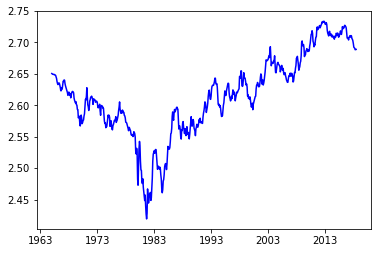

In [104]:
plt.plot(yx,y2['dur'],'b')
plt.show()

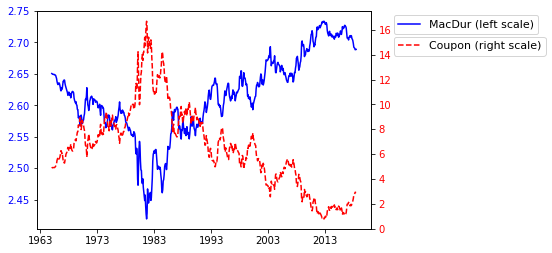

In [105]:
ax1 = plt.gca()
ax1.plot(yx,y2['dur'],'b',label='MacDur (left scale)')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.94), fontsize=11)

ax2 = ax1.twinx()
ax2.plot(yx,y2['cp'],'r--',label='Coupon (right scale)')
#ax2.set_ylabel('Worst 4% PD (%)',color='r')
#ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.84), fontsize=11)

#plt.title('f4_2: Worst 4% vs Best 96%')
#ax1.set_xlabel('Year')

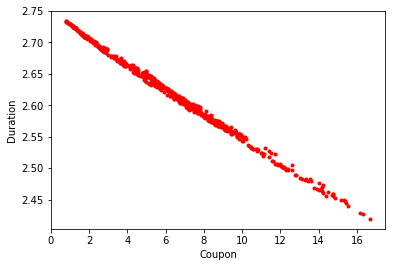

In [106]:
plt.plot(y2['cp'],y2['dur'],'r ',marker='.')
plt.ylabel('Duration')
plt.xlabel('Coupon')
plt.show()

In [107]:
y2.to_csv("Dur_60m_new_longhist.csv")

In [108]:
# calc 60m durations for all months (120m new aged 60m):
y = pd.DataFrame(columns=['dt','dur','cp'])
y['dt'] = pd.to_datetime(y['dt'])
mt = 120
for i in np.arange(len(spbig)-60):
  dt = spbig.index[i]
  x = dur2(dt,mt,60)
  cp = spbig.ix[dt,mt]
  y.loc[i] = [dt,x,cp]
  if i%100 == 0: print(i)
    
y3 = y.copy()

0
100
200
300
400
500


In [109]:
y3a= y3.set_index('dt',drop=True)
y3x = list(y3a.index)
y3a.tail()

dur    cp
dt                        
2013-03-01  2.691709  2.05
2013-04-01  2.690719  1.90
2013-05-01  2.688405  2.06
2013-06-01  2.688865  2.48
2013-07-01  2.688970  2.77

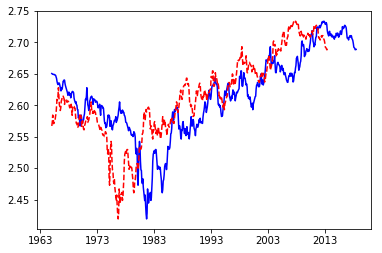

In [110]:
plt.plot(yx,y2['dur'],'b-')  # new 60m
plt.plot(y3x,y3a['dur'],'r--')  # aged 120m
plt.show()

In [111]:
## ladder processing:
dtlst = list(spbig.index)
len(dtlst) # 643

643

In [112]:
dtlstx = dtlst
for i in np.arange(1,61):
  dtlstx = dtlstx + [curym(dtlst[-1],i)]

#dtlstx = [pd.Timestamp(x) for x in dtlstx]
dtlstx[-5:]

[Timestamp('2023-03-01 00:00:00'),
 Timestamp('2023-04-01 00:00:00'),
 Timestamp('2023-05-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-07-01 00:00:00')]

In [113]:
len(dtlstx) # 703

703

In [114]:
pd.DataFrame(spbig.ix[0]).T

0         1         2         3        4        5    \
1965-01-01  3.954167  4.295444  4.504441  4.636722  4.70645  4.75833   

                 6         7         8         9      ...          351  \
1965-01-01  4.778666  4.773817  4.761695  4.745936    ...     4.929627   

                 352       353       354      355       356       357  \
1965-01-01  4.929383  4.929138  4.928894  4.92865  4.928406  4.928161   

                 358       359       360  
1965-01-01  4.927917  4.927672  4.927428  

[1 rows x 361 columns]

In [115]:
############################################################
############################################################
## ladder dur, MV section:

In [116]:
mt = 5*12  ## swap maturity 

In [117]:
ci = [x for x in np.arange(1,mt+1) if x%6==(mt%6)]  # get coupon dates for new swap
ci[-5:]

[36, 42, 48, 54, 60]

In [118]:
t2 = pd.Series(np.zeros(mt),index=np.arange(1,mt+1))  # temp table for processing
t2[-5:]

56    0.0
57    0.0
58    0.0
59    0.0
60    0.0
dtype: float64

In [119]:
# set-up tm to hold cf's
tm=pd.DataFrame(spbig.ix[0]).T
tm = tm[np.arange(1,mt+1)]
tm[np.arange(1,mt+1)] = 0
tm.tail()

1    2    3    4    5    6    7    8    9    10 ...    51   52  \
1965-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   

             53   54   55   56   57   58   59   60  
1965-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 60 columns]

In [120]:
## start sections to calc ladder durations and MVs:

In [121]:
ci[-5:]

[36, 42, 48, 54, 60]

In [122]:
for i in np.arange(mt): # fill up cash flows in 1st possible ladder
  cp = spbig.ix[i,mt]/2 # get coupon
  for j in np.arange(1,mt): # move prior month cash flows up by 1 month
    t2.loc[j] = t2.loc[j+1]
  t2.loc[mt] = 0        # zero out last cash flow
  t2[ci] = t2[ci]+cp    # assign coupons to payment periods
  t2[mt] = t2[mt]+100   # add return of principal to maturity period

In [123]:
cp

4.361602564

In [124]:
# temp df for appending to tm table:
d2 = pd.DataFrame(t2,columns=[spbig.index[mt-1].strftime('%Y-%m-%d')]).T
d2.index = pd.to_datetime(d2.index)
d2

1           2           3           4           5   \
1969-12-01  132.156026  130.486026  130.806026  130.676026  131.396026   

                    6           7           8           9           10  \
1969-12-01  131.956026  127.689423  128.029423  128.349423  128.219423   

               ...              51          52          53          54  \
1969-12-01     ...      107.753205  107.668205  107.798205  108.118205   

                    55          56          57          58          59  \
1969-12-01  103.886603  103.896603  104.166603  104.136603  104.146603   

                    60  
1969-12-01  104.361603  

[1 rows x 60 columns]

In [125]:
if tm.index[-1]< d2.index: tm=tm.append(d2)
if tm.ix[0][1] == 0: tm=tm.drop(tm.index[0])
tm

1           2           3           4           5   \
1969-12-01  132.156026  130.486026  130.806026  130.676026  131.396026   

                    6           7           8           9           10  \
1969-12-01  131.956026  127.689423  128.029423  128.349423  128.219423   

               ...              51          52          53          54  \
1969-12-01     ...      107.753205  107.668205  107.798205  108.118205   

                    55          56          57          58          59  \
1969-12-01  103.886603  103.896603  104.166603  104.136603  104.146603   

                    60  
1969-12-01  104.361603  

[1 rows x 60 columns]

In [126]:
for i in np.arange(mt,len(spbig)): # process another month:
  for j in np.arange(1,mt): # move prior month cash flows up by 1 month
    t2.loc[j] = t2.loc[j+1]
  t2.loc[mt] = 0        # zero out last cash flow
  cp = spbig.ix[i,mt]/2 # get coupon for new swap
  t2[ci] = t2[ci]+cp    # add new coupons to payment periods
  t2[mt] = t2[mt]+100   # add return of principal to maturity period
  d2 = pd.DataFrame(t2,columns=[spbig.index[i].strftime('%Y-%m-%d')]).T
  d2.index = pd.to_datetime(d2.index)
  tm=tm.append(d2)

In [127]:
tm.to_csv(str(mt)+'mLadder_cfs_longhist.csv')

In [128]:
str(mt)+'mLadder_cfs_longhist.csv'

'60mLadder_cfs_longhist.csv'

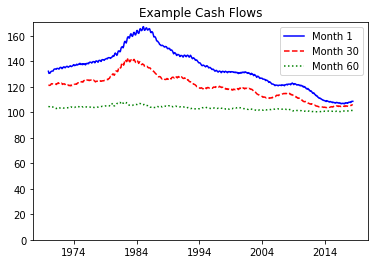

In [129]:
tmx = list(tm.index)
plt.plot(tmx,tm[1],'b-',label='Month 1')
plt.plot(tmx,tm[mt/2],'r--',label='Month '+str(int(mt/2)))
plt.plot(tmx,tm[mt],'g:',label='Month ' + str(mt))
plt.ylim(ymin=0)
plt.legend(loc=0)
plt.title('Example Cash Flows')
plt.show()

In [130]:
# calc MacDurs and MVs:

In [131]:
ts = list(tm.columns)
ts = [x/12 for x in ts]
ts[-5:]  # list of yrs for dur calcs

[4.666666666666667, 4.75, 4.833333333333333, 4.916666666666667, 5.0]

In [132]:
dv = pd.DataFrame(tm[[1,2,3,4]])
dv.columns = ['mv','mvpc','dur','cpn']
dv[['mv','mvpc','dur','cpn']] = [0,0,0,0]
dv.head()

mv  mvpc  dur  cpn
1969-12-01  0.0   0.0  0.0  0.0
1970-01-01  0.0   0.0  0.0  0.0
1970-02-01  0.0   0.0  0.0  0.0
1970-03-01  0.0   0.0  0.0  0.0
1970-04-01  0.0   0.0  0.0  0.0

In [133]:
## calc dur, mv, mv% for all ladders:
for i in np.arange(len(tm)):
  pv= [x*y for x,y in zip(tm.ix[i][0:mt],list(df_sp.loc['df',tm.index[i]])[1:mt+1])] ## mult 2 vectors: cf*df
  pvt= [x*y for x,y in zip(pv,ts)]
  dv.ix[i]['dur'] = sum(pvt)/sum(pv)
  dv.ix[i]['mv'] = sum(pv) - 100*mt
  dv.ix[i]['mvpc'] = sum(pv) / (100*mt)
  dv.ix[i]['cpn'] = spbig.ix[dv.index[i]][mt] # pull coupon for swap maturity mt

In [134]:
dv[0:2]

mv      mvpc       dur       cpn
1969-12-01 -196.139001  0.967310  2.260266  8.723205
1970-01-01 -203.975953  0.966004  2.256081  8.933205

In [135]:
## calc MV3m:  
b3 = mt/12  # balance per month repricing
mv3 = pd.DataFrame(spbig[3])
mv3.rename(columns={3:'rt'},inplace=True)
df3 = mv3.merge(df_sp.loc['df'][[1,2,3]],how='left',left_index=True,right_index=True)
df3['cf1'] = df3['rt'].shift(2) * b3 + mt*100/3
df3['cf2'] = df3['rt'].shift(1) * b3 + mt*100/3
df3['cf3'] = df3['rt'] * b3 + mt*100/3
df3['mv3'] = df3[1]*df3['cf1']+df3[2]*df3['cf2']+df3[3]*df3['cf3'] - mt*100
df3.head()

rt         1         2         3          cf1          cf2  \
Date                                                                           
1965-01-01  4.636722  0.996433  0.992549  0.988541          NaN          NaN   
1965-02-01  4.758389  0.996349  0.992349  0.988244          NaN  2023.183609   
1965-03-01  4.758389  0.996324   0.99233  0.988244  2023.183609  2023.791943   
1965-04-01  4.758389  0.996303  0.992314  0.988244  2023.791943  2023.791943   
1965-05-01  4.717833  0.996316  0.992366  0.988343  2023.791943  2023.791943   

                    cf3      mv3  
Date                              
1965-01-01  2023.183609      NaN  
1965-02-01  2023.791943      NaN  
1965-03-01  2023.791943  24.0159  
1965-04-01  2023.791943  24.5469  
1965-05-01  2023.589165  24.6787

In [136]:
dv['mv3'] = df3['mv3']
dv.head()

mv      mvpc       dur       cpn      mv3
1969-12-01 -196.139001  0.967310  2.260266  8.723205  35.5111
1970-01-01 -203.975953  0.966004  2.256081  8.933205  39.4302
1970-02-01 -138.245113  0.976959  2.261902  8.583205  45.3042
1970-03-01  -46.897398  0.992184  2.272597  7.973205  45.3873
1970-04-01  -76.880535  0.987187  2.267233  8.263205  39.1301

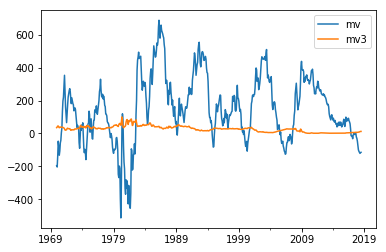

In [137]:
dv[['mv','mv3']].plot()

In [138]:
#roll3m = pd.DataFrame(pd.rolling_mean(spbig[3],3, min_periods=3),columns=['roll3m'])
roll3m = pd.DataFrame(spbig[3].rolling(3, min_periods=3).mean())
roll3m.columns = ['roll3m']
spbiga = spbig[mt].rolling(mt, min_periods=mt).mean()
spbiga.dropna(inplace=True)
spbiga.head()

Date
1969-12-01    6.181372
1970-01-01    6.249205
1970-02-01    6.310372
1970-03-01    6.361372
1970-04-01    6.417205
Name: 60, dtype: float64

In [139]:
#roll3m.columns = ['roll3m']
roll3m.head()

roll3m
Date                
1965-01-01       NaN
1965-02-01       NaN
1965-03-01  4.717833
1965-04-01  4.758389
1965-05-01  4.744870

In [140]:
dv['roll'+str(mt)+'m'] = spbiga
dv = dv.merge(roll3m, how='left',left_index=True, right_index=True)
dv.tail()

mv      mvpc       dur       cpn      mv3   roll60m  \
2018-03-01 -108.859821  0.981857  2.452329  2.764476  8.40516  1.680937   
2018-04-01 -114.674680  0.980888  2.450938  2.826143  10.0018  1.713373   
2018-05-01 -121.154029  0.979808  2.448484  2.927636  12.2626  1.745500   
2018-06-01 -117.145721  0.980476  2.448772  2.914524  12.7122  1.771075   
2018-07-01 -114.455100  0.980924  2.448665  2.916905  12.5891  1.793357   

              roll3m  
2018-03-01  1.954102  
2018-04-01  2.162103  
2018-05-01  2.317883  
2018-06-01  2.370911  
2018-07-01  2.367428

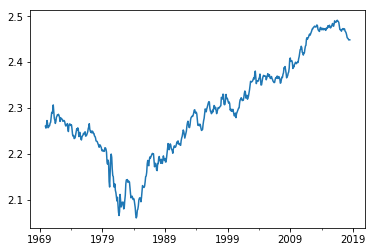

In [141]:
dv['dur'].plot()

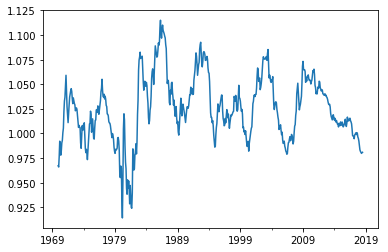

In [142]:
dv['mvpc'].plot()

In [143]:
dv.to_csv('durmv_'+str(mt)+'mladder_longhist.csv')
'durmv_'+str(mt)+'mladder_longhist.csv'

'durmv_60mladder_longhist.csv'

In [144]:
'durmv_'+str(mt)+'mladder_longhist.csv'

'durmv_60mladder_longhist.csv'

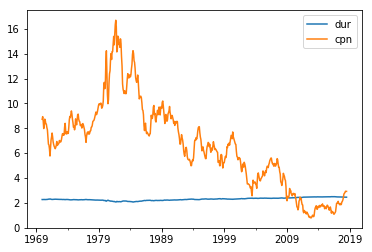

In [145]:
dv[['dur','cpn']].plot()

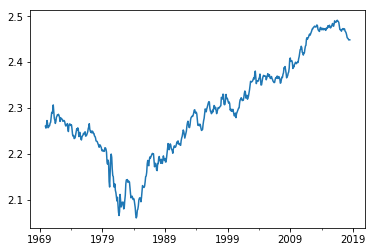

In [146]:
dv['dur'].plot()

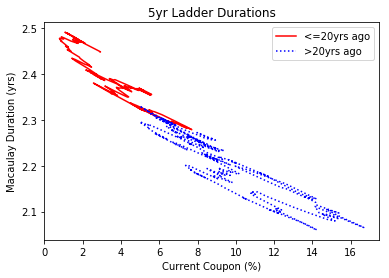

In [147]:
### NOTE: Change to use 20 yrs ending Dec-2015!!!!!!!!!!!
###    this code uses latest 20 yrs (up to Dec-2017)...
###    This was fixed in br006caba... code (May-2018)

plt.plot(dv['cpn'][-240:],dv['dur'][-240:],'r-',label='<=20yrs ago')
plt.plot(dv['cpn'][0:-240],dv['dur'][0:-240],'b:',label='>20yrs ago')
plt.ylabel('Macaulay Duration (yrs)')
plt.xlabel('Current Coupon (%)')
plt.legend(loc=0)
plt.title(str(int(mt/12))+'yr Ladder Durations')
plt.show()

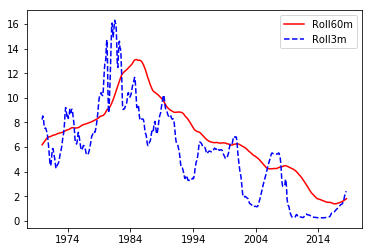

In [148]:
dx = list(dv.index)
plt.plot(dx, dv['roll'+str(mt)+'m'],'r-',label='Roll'+str(mt)+'m')
plt.plot(dx, dv['roll3m'],'b--',label='Roll3m')
plt.legend(loc=0)
plt.show()

In [149]:
dv['dur'][-240:].mean()

2.3978753401275834

In [150]:
dv['dur'][-240:].mean()/(mt/12/2) # .950: 20y 5y ladder vs naive (10:.857; 8:.893; 7:.912, 6:.931; 4:.970; 3:.992; 2:1.012)

0.9591501360510334

In [151]:
tm.tail(2)

1           2           3           4           5   \
2018-06-01  108.632349  108.599025  108.927991  108.626255  108.994704   
2018-07-01  108.599025  108.927991  108.626255  108.994704  109.351934   

                    6           7           8           9           10  \
2018-06-01  109.351934  107.842349  107.759025  108.047991  107.871255   
2018-07-01  109.300801  107.759025  108.047991  107.871255  108.259704   

               ...              51          52          53          54  \
2018-06-01     ...      102.315513  102.439976  102.520913  102.574437   
2018-07-01     ...      102.439976  102.520913  102.574437  102.676976   

                    55          56          57          58          59  \
2018-06-01  101.218524  101.351250  101.382238  101.413071  101.463818   
2018-07-01  101.351250  101.382238  101.413071  101.463818  101.457262   

                    60  
2018-06-01  101.457262  
2018-07-01  101.458452  

[2 rows x 60 columns]

In [152]:
mt

60

In [153]:
dv.tail()

mv      mvpc       dur       cpn      mv3   roll60m  \
2018-03-01 -108.859821  0.981857  2.452329  2.764476  8.40516  1.680937   
2018-04-01 -114.674680  0.980888  2.450938  2.826143  10.0018  1.713373   
2018-05-01 -121.154029  0.979808  2.448484  2.927636  12.2626  1.745500   
2018-06-01 -117.145721  0.980476  2.448772  2.914524  12.7122  1.771075   
2018-07-01 -114.455100  0.980924  2.448665  2.916905  12.5891  1.793357   

              roll3m  
2018-03-01  1.954102  
2018-04-01  2.162103  
2018-05-01  2.317883  
2018-06-01  2.370911  
2018-07-01  2.367428